In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from tqdm.notebook import trange, tqdm

In [2]:
N = 1024

np.random.seed(0)
torch.manual_seed(0)
theta = np.sqrt(np.random.rand(N)) * 3 * np.pi
r_a = 2 * theta + np.pi
x1 = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
x1 = 4*(x1 + 0.25 *np.random.randn(N,2) + 30)
x1 = x1.astype('uint8')
#x1_mean = x1.mean(axis=0)
#x1_std = x1.std(axis=0)

#theta = np.random.rand()
r_a = 10
x2 = np.array([np.cos(theta)* r_a, np.sin(theta) * r_a + 2]).T
x2 = 4*(x2 + 0.25 *np.random.randn(N,2) + 30)
x2 = x2.astype('uint8')
#x2_mean = x2.mean(axis=0)
#x2_std = x2.std(axis=0)




In [3]:
spiral = np.append(x1, np.repeat(1, len(x1)).reshape(1024,1), axis=1)
circle = np.append(x2, np.repeat(0, len(x2)).reshape(1024,1), axis=1)

In [4]:
data = np.vstack((spiral, circle))
np.random.shuffle(data)

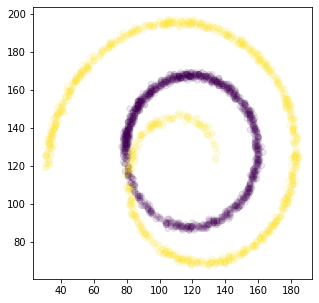

In [5]:
fig = plt.figure(figsize=(5,5))
plt.scatter(data[:, 0], data[:, 1],c=data[:,2], alpha=0.1)
plt.show()

In [6]:
x = torch.from_numpy(data[:,:2])
x_mean = torch.from_numpy(data[:,:2].mean(axis=0)).type(torch.float32)
x_std = torch.from_numpy(data[:, :2].std(axis=0)).type(torch.float32)
y = torch.from_numpy(data[:,2])

In [7]:
class Base2FourierFeatures(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, inputs):
        freqs = torch.asarray(range(8), dtype=inputs.dtype) # [0,1,...,7]
        w = 2*torch.pi * (2.0**freqs) # 2^n * 2π
        # concatenate a copy of w column-wise
        w = torch.tile(w[None, :], (1, inputs.shape[-1]))
        # repeat input array 8 times for 8 frequencies column-wise
        h = 1.0*torch.repeat_interleave(inputs, repeats=len(freqs), dim=-1)
        #element-wise multiplication (x*2^n *2π)
        h *= w
        # apply sin and cosine to and concatenate column-wise
        h = torch.cat([torch.sin(h), torch.cos(h)], axis=-1)
        return h
        

In [8]:
init_gamma_0 = -13.3  # initial gamma_0
init_gamma_1 = 5.0  # initial gamma_1
class NoiseSchedule(nn.Module):
    def __init__(self):
        super().__init__()
        init_bias = init_gamma_0
        init_scale = init_gamma_1 - init_gamma_0
        
        self.w = nn.Parameter(data=torch.tensor([init_scale]))
        self.b = nn.Parameter(data=torch.tensor([init_bias]))
        
    def forward(self, t):
        return torch.abs(self.w)*t + self.b

In [9]:
hidden_units = 512
class ScoreNetwork(nn.Module):
    def __init__(self, num_classes=None, cond_prob=None):
        super().__init__()

        self.layer1 = nn.LazyLinear(hidden_units)
        self.layer2 = nn.LazyLinear(hidden_units)
        self.layer3 = nn.LazyLinear(2)

        self.layer_fourier = Base2FourierFeatures()

        if num_classes is not None:
          self.class_emb = nn.Embedding(num_classes, 10)

        if cond_prob is not None:
          self.cond_prob = cond_prob          
        
    def forward(self, z, gamma_t, y=None, class_free=False):
        gamma_lower_bound = init_gamma_0
        gamma_upper_bound = init_gamma_1
        
        # Normalize gamma_t
        gamma_t_norm = ((gamma_t - gamma_lower_bound) / (gamma_upper_bound - gamma_lower_bound)) *2 -1
        
        # Concatenate normalized gamma_t as extra feature
        x = torch.cat([z, gamma_t_norm[:, None]], axis=1) # CHANGED -1 TO 1

        if class_free:
          #assert(self.cond_prob is not None)
          if (self.training):  # randomly set embeddings to zeros while training with self.cond_prob
            if np.random.uniform() < self.cond_prob:
              x_class_emb = torch.zeros((x.shape[0], 10))
            else:
              x_class_emb = self.class_emb(y)
          else:
             if y is None: # if y=None during inference, set embeddings to zeros
               x_class_emb = torch.zeros((x.shape[0], 10))
             else:
                x_class_emb = self.class_emb(y)
                
        else:
          x_class_emb = self.class_emb(y)

        x = torch.cat([x, x_class_emb], axis=1)


        # append Fourier features
        x_fourier = self.layer_fourier(x)

        x = torch.cat([x, x_fourier], axis=1)
        #if y is not None:
        #  if (self.training):
        #    if np.random.uniform() < self.cond_prob:
        #      y = torch.tensor([2]).repeat(2048)
        #      x_class_emb = self.class_emb(y)
        #    else:
        #      x_class_emb = self.class_emb(y)
        #  else:
        #    x_class_emb = self.class_emb(y)          
          
          

        # forward pass
        x = F.silu(self.layer1(x))

        x = F.silu(self.layer2(x))

        return self.layer3(x)

In [10]:
class Diffusion_Model(nn.Module):
    def __init__(self, num_classes=None, cond_prob=None):
        super().__init__()
        self.score_network = ScoreNetwork(num_classes=num_classes, cond_prob=cond_prob)
        self.noise_schedule = NoiseSchedule()
        
    def forward(self, x, t, y, class_free):
        gamma_t = self.noise_schedule(t)
        return self.score_network(x, gamma_t, y, class_free=class_free)
    
    def score(self, x, t, y, class_free):
        return self.score_network(x, t, y, class_free=class_free)
        
    
    def gamma(self, t):
        return self.noise_schedule(t)

In [11]:
def data_encode(x):
    x = x.round()
    return (x- x_mean) / x_std

In [12]:
vocab_size = 256

def data_decode(x_0_rescaled, gamma_0):
    
    x_vals = torch.arange(0, vocab_size)[:, None]
    x_vals = torch.repeat_interleave(x_vals, repeats=x_0_rescaled.shape[-1], dim=1)
    x_vals = data_encode(x_vals).transpose(1, 0)[None, :, :]
    inv_stdev = torch.exp(-0.5 * gamma_0[..., None])
    logits = -0.5 * torch.square((x_0_rescaled[..., None] - x_vals) * inv_stdev)
    logprobs = F.log_softmax(logits, dim=2)
    return logprobs

In [13]:
def data_logprob(x, x_0_rescaled, gamma_0):
    x = x.round()
    x_onehot = F.one_hot(x.type(dtype=torch.int64), vocab_size).type(torch.float32)
    logprobs = data_decode(x_0_rescaled, gamma_0)
    logprob = torch.sum(x_onehot * logprobs, dim=(1, 2))
    return logprob

In [16]:
T_train =2000
model = Diffusion_Model(num_classes=2, cond_prob=0.2)
def loss_fn(x, y):
    
    gamma = lambda t: model.gamma(t)
    gamma_0, gamma_1 = gamma(0.0), gamma(1.0)
    var_0, var_1 = torch.sigmoid(gamma_0), torch.sigmoid(gamma_1)
    n_batch = x.shape[0]
    
    f = data_encode(x)
    
    # RECONSTRUCTION LOSS
    eps_0 = torch.randn(size=f.shape)
    x_0 = torch.sqrt(1.0 - var_0)*f + torch.sqrt(var_0) * eps_0
    x_0_rescaled = f + torch.exp(0.5*gamma_0) * eps_0
    loss_recon = -data_logprob(x, x_0_rescaled, gamma_0)
    
    # LATENT LOSS
    mean1_sqr = (1.0 - var_1) * torch.square(f)
    loss_klz = 0.5*torch.sum(mean1_sqr + var_1 - torch.log(var_1) -1.0, dim=1)
    
    # DIFFUSION LOSS
    t = torch.rand(size=(n_batch,))
    # sample time steps
    if T_train >0:
        t = torch.ceil(t * T_train) / T_train
    # sample z_t
    gamma_t = gamma(t)
    var_t = torch.sigmoid(gamma_t)[:, None]
    eps = torch.randn(size=f.shape)
    x_t = torch.sqrt(1.0 - var_t)*f + torch.sqrt(var_t) * eps
    x_t = x_t.type(torch.FloatTensor)
    # compute predicted noise
    eps_hat = model.score(x_t, gamma_t, y, class_free=True)

    loss_diff_mse = torch.sum(torch.square(eps - eps_hat), dim=1)
    
    # loss for discrete time
    s = t- (1.0 / T_train)
    gamma_s = gamma(s)
    loss_diff = 0.5*T_train*torch.expm1(gamma_t - gamma_s) * loss_diff_mse
    
    # compute loss in terms of bits per dimension
    rescale_to_bpd = 1.0 / (torch.prod(torch.tensor(x.shape[1:])) * torch.log(torch.tensor(2.0)))
    bpd_latent = torch.mean(loss_klz) * rescale_to_bpd
    bpd_recon = torch.mean(loss_recon) * rescale_to_bpd
    bpd_diff = torch.mean(loss_diff) * rescale_to_bpd
    bpd = bpd_recon + bpd_latent + bpd_diff
    loss = bpd
    metrics = [bpd_latent, bpd_recon, bpd_diff]
    return loss, metrics


In [17]:
learning_rate = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_step(x, y):
    x = x.type('torch.FloatTensor')
    model.train()
    optimizer.zero_grad()
    (loss, metrics) = loss_fn(x,y)
    loss.backward()
    optimizer.step()
    return loss, metrics

In [ ]:
num_train_steps = 20000
losses = []

for i in trange(num_train_steps):
    loss, _metrics = train_step(x,y)
    losses.append(loss.detach().numpy())

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
model.eval()

def sample_step(i, T_sample, x_t, y_cond, w=None):
  eps = torch.randn(x_t.shape)
  t = (T_sample - i) / T_sample
  s = (T_sample - i - 1) / T_sample

  gamma_s = model.gamma(s)
  gamma_t = model.gamma(t)
  gamma_s = gamma_s * torch.ones((x_t.shape[0],), dtype=gamma_s.dtype)
  gamma_t = gamma_t *  torch.ones((x_t.shape[0],), dtype=gamma_t.dtype)

  #y_cond = y_cond.repeat(x_t.shape[0])
  #y_uncond = torch.tensor([2]).repeat(x_t.shape[0])
  eps_hat_uncond = model.score(x_t, gamma_t, y=None, class_free=True)
  eps_hat_cond = model.score(x_t, gamma_t, y=y_cond, class_free=True)

  eps_hat = w*eps_hat_cond + (1-w)*eps_hat_uncond


  a = torch.sigmoid(-gamma_s)[:, None]
  b = torch.sigmoid(-gamma_t)[:, None]
  c = -torch.expm1(gamma_s - gamma_t)[:, None]
  sigma_t = torch.sqrt(torch.sigmoid(gamma_t))[:, None]

  sigma2_s_t = (1.0 - a) * c
  sigma2_t_s = (1.0 - b) * c

  x_s = torch.sqrt(a / b) * (x_t - sigma_t * c * eps_hat) + torch.sqrt((sigma2_s_t**(1-w))*(sigma2_t_s**w)) * eps

  alpha_t = torch.sqrt(1 - b)
  x_pred = (x_t - sigma_t * eps_hat) / alpha_t

  return x_s, x_pred

In [ ]:
def data_generate_x(x_0, gamma_0):
  var_0 = torch.sigmoid(gamma_0)
  x_0_rescaled = x_0/torch.sqrt(1.0 - var_0)
  logits = data_decode(x_0_rescaled, gamma_0)
  samples = torch.empty(size=logits.shape[:-1], dtype=torch.int32)
  for i in range(logits.shape[0]):
    samples[i,:] = torch.multinomial(input=F.softmax(logits, dim=-1)[i,:,:], num_samples=1).reshape(-1).type(torch.int32)
  return samples

In [ ]:
def sample_fn(N_sample, T_sample, w, _class=1):

  x = [torch.randn(size=(N_sample,2))]
  x_pred = []
  for i in trange(T_sample):
    _x, _x_pred = sample_step(i, T_sample, x[-1], w=w, y_cond=torch.tensor([_class]).repeat(x[-1].shape[0]))
    x.append(_x)
    x_pred.append(_x_pred)

  gamma_0 = model.gamma(0.0)
  x_sample = data_generate_x(x[-1], gamma_0)
  return x, x_pred, x_sample

In [ ]:
x, x_pred, _ = sample_fn(N_sample=1024, T_sample=200, w = 0.3, _class=1)

  0%|          | 0/200 [00:00<?, ?it/s]

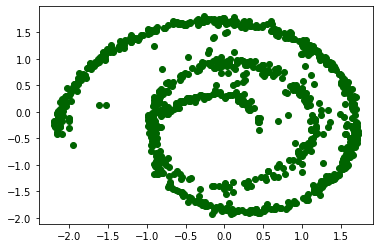

In [ ]:
import matplotlib.colors as mcolors
data = x[190].detach().numpy()
plt.scatter(data[:,0], data[:,1], color='darkgreen')

#Classifier-free Guidance